## CS studies with rarefy and 10's

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
from skbio.stats import subsample_counts
from biom import load_table
from gneiss.cluster import correlation_linkage
from gneiss.util import rename_internal_nodes, match
from gneiss.balances import balance_basis
from skbio.stats.composition import ilr
import skbio
import qiime2

import dsfdr
import statistics
import transform

%matplotlib notebook
import matplotlib.pyplot as plt
import pylab

In [4]:
def convert_biom_to_pandas(table):
    otu_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    return otu_table

In [71]:
table = load_table('../data/cs.biom')
otu_table = convert_biom_to_pandas(table)
otu_table.shape

(290, 2817)

In [72]:
# rarefy
otu_table2 = np.array(otu_table).astype(int)
otu_sum = np.sum(otu_table2, axis=1)
sp.stats.describe(otu_sum)

DescribeResult(nobs=290, minmax=(1, 5160), mean=1599.5103448275861, variance=519695.24729745858, skewness=0.9514982056932724, kurtosis=3.0885957924253225)

In [73]:
labels = np.array(otu_sum >= 1000) # minmax = (1k, 10k)
otu_table3 = otu_table2[labels==True, :]
otu_table3.shape

(235, 2817)

In [74]:
otu_table_r = np.zeros(np.shape(otu_table3))
for i in range(np.shape(otu_table3)[0]):
    col_r = subsample_counts(otu_table3[i, :], 1000)
    otu_table_r[i, :] = col_r

In [75]:
# generate the tree
otu_table_r = pd.DataFrame(otu_table_r)
otu_tree = correlation_linkage(otu_table_r + 1)

In [76]:
basis, _ = balance_basis(otu_tree)
balances = ilr(otu_table_r + 1, basis)

In [77]:
balance_ids = [n.name for n in otu_tree.levelorder() if not n.is_tip()]
balances_df = pd.DataFrame(balances, index=otu_table.index[labels], columns=balance_ids)

In [78]:
mapping=pd.read_table("../data/cs.map.txt", sep='\t', header=0, index_col=0)

In [79]:
mapping['smoker'].value_counts()

True     148
False    143
Name: smoker, dtype: int64

In [80]:
mapping, balances_df = match(mapping, balances_df)

In [81]:
# fix floating point error in balances output
balances_df = np.array(balances_df)
for col in range(np.shape(balances_df)[1]):
    for row in range(np.shape(balances_df)[0]):
        close = np.isclose(balances_df[row, col], balances_df[:, col])
        balances_df[close, col] = balances_df[row, col] 

In [82]:
balances_cs = np.transpose(balances_df)
labels_cs = np.array((mapping['smoker'] == False).astype(int))

In [83]:
print(balances_cs.shape)
print(labels_cs.shape)

(2816, 235)
(235,)


In [92]:
results1 = dsfdr.dsfdr(data = balances_cs, labels = labels_cs, fdr_method='dsfdr')
results2 = dsfdr.dsfdr(data = balances_cs, labels = labels_cs, fdr_method='bhfdr')

In [93]:
ds = np.sum(results1[0])
bh = np.sum(results2[0])
print(ds, bh, ds-bh, (ds-bh)/bh*100)

822 745 77 10.3355704698


In [94]:
pvals = results1[2]

556.229173171


<IPython.core.display.Javascript object>


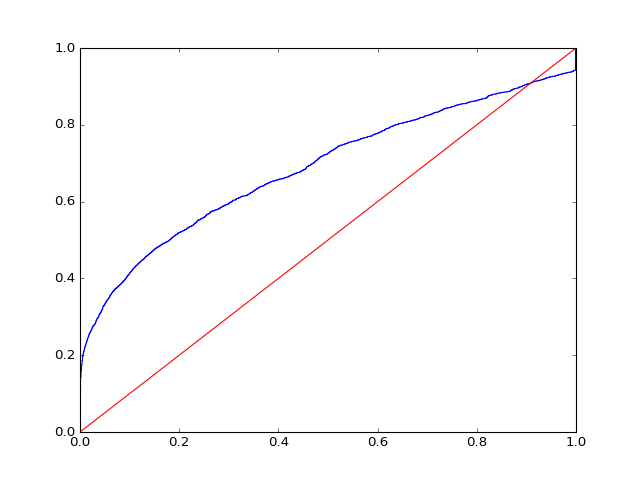

In [95]:
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import linalg as LA

sample = pvals
ecdf = ECDF(sample)

x = np.sort(sample)
y = ecdf(x)
print(LA.norm(x - y, 1))

plt.figure()
plt.step(x, y)
plt.plot(x, x, color = 'red')